In [1]:
# mostly pulled from hls4ml_3.ipynb and waveform_demo.ipynb
# last updated 2025-05-04 by mza
name = "mza_try2"
num_epochs = 200
batch_size = 1000
hidden_nodes = [ 1024 ]
hidden_node_type = "sigmoid"
#truths_to_use = [ 0, 2, 3 ]
#truths_to_use = [ 0 ] # great
#truths_to_use = [ 1 ] # not good
#truths_to_use = [ 2 ] # not good
#truths_to_use = [ 3 ] # not bad
#truths_to_use = [ 0, 1 ]
#truths_to_use = [ 2, 3 ] # hidden = [32] shows anti-correlation
truths_to_use = [ 0, 3 ]
#truths_to_use = [ 0, 1, 2, 3 ]

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['PATH'] = os.environ['XILINX_VIVADO'] + '/bin:' + os.environ['PATH']
import numpy as np
seed = 0
np.random.seed(seed)
import matplotlib.pyplot as plt

In [3]:
dataset1 = np.load('waveform_data_0.npy') # (10000, 104)
dataset2 = np.load('waveform_data_1.npy') # (10000, 104)
#print(str(dataset1.shape))
#print(str(dataset2.shape))
dataset = np.concatenate((dataset1, dataset2))
#print(str(dataset.shape))
#dataset = np.load('waveform_data_1.npy') # (10000, 104)
if 0:
    subset = []
    for i in range(len(dataset)):
        if 35 <= dataset[i,0] and dataset[i,0] < 45:
            subset.append(dataset[i])
    subset = np.array(subset)
    dataset = subset
num_waveforms = len(dataset)
training_quantity = int(0.8 * num_waveforms)
num_truths = 4
time_samples = len(dataset[0]) - num_truths
print("num_waveforms: " + str(num_waveforms))
#print("time_samples: " + str(time_samples))
#print("num_truths: " + str(num_truths))
num_truths_to_use = len(truths_to_use)
print("num_truths_to_use: " + str(num_truths_to_use))
waveforms = dataset[:,num_truths:]
truths = dataset[:,:num_truths]
#print("waveforms: " + str(waveforms.shape))
#print("waveforms[0]: " + str(waveforms[0]))
#print("truths: " + str(truths.shape))
#print("truths[0]: " + str(truths[0])) # t_peak, t_sigma, height, pedestal
waveform_min = min([ min(waveforms[i]) for i in range(len(waveforms)) ])
waveform_max = max([ max(waveforms[i]) for i in range(len(waveforms)) ])
#print("waveform_max: " + str(waveform_max))
#print("waveform_min: " + str(waveform_min))
offset = waveform_min
gain = 1.0 / (waveform_max - waveform_min)
#print("offset: " + str(offset))
#print("gain: " + str(gain))
scaled_waveforms = np.array([ [ gain * (waveforms[j,i] - offset) for i in range(time_samples) ] for j in range(num_waveforms) ])
#print("scaled_waveforms: " + str(scaled_waveforms.shape))
#print(str(scaled_waveforms[0]))
scaled_truths = np.array([ [ truths[j,0]/time_samples, truths[j,1]/time_samples, gain * (truths[j,2] - offset), gain * (truths[j,3] - offset) ] for j in range(num_waveforms) ])
#print("scaled_truths: " + str(scaled_truths.shape))
#print(str(scaled_truths[0]))

train_data = scaled_waveforms[:training_quantity,:]
print("train_data.shape: " + str(train_data.shape))
train_truth = scaled_truths[:training_quantity,truths_to_use]
print("train_truth.shape: " + str(train_truth.shape))
test_data = scaled_waveforms[training_quantity:,:]
print("test_data.shape: " + str(test_data.shape))
test_truth = scaled_truths[training_quantity:,truths_to_use]
print("test_truth.shape: " + str(test_truth.shape))
#print(sample_0)

num_waveforms: 20000
num_truths_to_use: 2
train_data.shape: (16000, 100)
train_truth.shape: (16000, 2)
test_data.shape: (4000, 100)
test_truth.shape: (4000, 2)


In [4]:
evt = 8
if 0:
    x = np.zeros(time_samples)
    for i in range(time_samples):
        x[i] = i/time_samples
    y = train_data[evt]
    plt.xlim(0, 1), plt.ylim(0, 1)
    plt.scatter(x, y)
    plt.plot([train_truth[evt][0], train_truth[evt][0]], [0.0, 1.0], color="green")
    #plt.plot([train_truth[evt][0]-train_truth[evt][1], train_truth[evt][0]-train_truth[evt][1]], [0.0, 1.0], color="green")
    #plt.plot([train_truth[evt][0]+train_truth[evt][1], train_truth[evt][0]+train_truth[evt][1]], [0.0, 1.0], color="green")
    #plt.plot([0.0, 1.0], [train_truth[evt][2]+train_truth[evt][3], train_truth[evt][2]+train_truth[evt][3]], color="green")
    #plt.plot([0.0, 1.0], [train_truth[evt][3], train_truth[evt][3]], color="green")
    plt.show()

In [5]:
## The truth
print("time position of the peak: ", train_truth[evt][0]) # The 0th column: mean of the Gaussian peak
#print("sigma of the peak: ", train_truth[evt][1]) # The 1st column: sigma of the Gaussian peak
#print("height of the peak: ", train_truth[evt][2]) # The 2nd column: height of the Gaussian peak
#print("pedestal of the waveform: ", train_truth[evt][3]) # The 3rd column: pedestal of the waveform

time position of the peak:  0.6038360595703125


In [6]:
import tensorflow as tf
tf.random.set_seed(seed)
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l1
from tensorflow.keras.layers import Activation
from tensorflow.keras import optimizers
from callbacks import all_callbacks
from qkeras.qlayers import QDense, QActivation
from qkeras.quantizers import quantized_bits, quantized_relu, quantized_sigmoid

In [7]:
if hidden_node_type=="relu":
    hidden_activations = [ quantized_relu(16) for i in range(len(hidden_nodes)) ]
    hidden_names = [ hidden_node_type for i in range(len(hidden_nodes)) ]
else:
    hidden_activations = [ quantized_sigmoid(16) for i in range(len(hidden_nodes)) ]
    hidden_names = [ hidden_node_type for i in range(len(hidden_nodes)) ]
model = Sequential()
model.add(QDense(100, input_shape=(100,), name='fc1', kernel_quantizer=quantized_bits(16, 8, alpha=1), bias_quantizer=quantized_bits(16, 8, alpha=1), kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
#model.add(QActivation(activation=quantized_relu(16), name='relu'))
model.add(QActivation(activation=quantized_sigmoid(16), name='sigmoid'))
for i in range(len(hidden_nodes)):
    model.add(QDense(hidden_nodes[i], name=hidden_names[i] + str(i) + "qdense", kernel_quantizer=quantized_bits(16, 8, alpha=1), bias_quantizer=quantized_bits(16, 8, alpha=1), kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
    model.add(QActivation(activation=hidden_activations[i], name=hidden_names[i] + str(i) + "activation"))
model.add(QDense(num_truths_to_use, name='output', kernel_quantizer=quantized_bits(16, 8, alpha=1), bias_quantizer=quantized_bits(16, 8, alpha=1), kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
if num_truths_to_use<2:
    model.add(Activation(activation='sigmoid', name='sigmoidout'))
else:
    model.add(Activation(activation='softmax', name='softmaxout'))

In [8]:
from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
from tensorflow_model_optimization.sparsity.keras import strip_pruning
if 0:
    # Here, 0.1 means that 10% of the weights will be forced to be 0.
    pruning_params = {"pruning_schedule": pruning_schedule.ConstantSparsity(0.1, begin_step=2000, frequency=100)}
    model = prune.prune_low_magnitude(model, **pruning_params)

In [9]:
train = True
if train:
    optimizer = optimizers.Adam(learning_rate=0.0001)
    #optimizer = optimizers.SGD(learning_rate=0.1)
    #model.compile(optimizer=optimizer, loss=['categorical_crossentropy'], metrics=['accuracy'])
    model.compile(optimizer=optimizer, loss=['mse'], metrics=['accuracy'])
    callbacks = all_callbacks(stop_patience=1000, lr_factor=0.5,
        lr_patience=10, lr_epsilon=0.000001,
        lr_cooldown=2, lr_minimum=0.0000001,
        outputDir=name)
    #callbacks.callbacks.append(pruning_callbacks.UpdatePruningStep())
    model.fit(train_data, train_truth, batch_size=batch_size, epochs=num_epochs,
        validation_split=0.25, shuffle=True,
        #callbacks=callbacks.callbacks,
        verbose=0)
    loss, acc = model.evaluate(test_data, test_truth, verbose=0)
    #model = strip_pruning(model)
    model.save(name + '/KERAS_check_best_model.keras')
else:
    from tensorflow.keras.models import load_model
    from qkeras.utils import _add_supported_quantized_objects
    co = {}
    _add_supported_quantized_objects(co)
    model = load_model(name + '/KERAS_check_best_model.keras', custom_objects=co)

/root/build/anaconda3/envs/hls4ml-tutorial/lib/python3.10/site-packages/keras/src/constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'qkeras.quantizers.quantized_bits'>, which may lead to improper serialization.
  warnings.warn(


In [10]:
print('test_acc: {:.3f}, test_loss: {:.3f}'.format(acc, loss))
train_prediction = model.predict(train_data)
test_prediction = model.predict(test_data)
#print(str(train_prediction.shape))
#print(str(test_prediction.shape))

test_acc: 0.905, test_loss: 0.045
125/125 [==============================] - 1s 6ms/step


In [11]:
if 0:
    evt = 5
    print(str(test_prediction[evt]) + " : " + str(test_truth[evt]))
    x = np.zeros(time_samples)
    for i in range(time_samples):
        x[i] = i/time_samples
    y = test_data[evt]
    plt.xlim(0, 1), plt.ylim(0, 1)
    plt.scatter(x, y, color="blue")
    plt.plot([test_prediction[evt,0], test_prediction[evt,0]], [0.0, 1.0], color="red")
    #plt.plot([test_prediction[evt][0]-test_prediction[evt][1], test_prediction[evt][0]-test_prediction[evt][1]], [0.0, 1.0], color="red")
    #plt.plot([test_prediction[evt][0]+test_prediction[evt][1], test_prediction[evt][0]+test_prediction[evt][1]], [0.0, 1.0], color="red")
    #plt.plot([0.0, 1.0], [test_prediction[evt][2]+test_prediction[evt][3], test_prediction[evt][2]+test_prediction[evt][3]], color="red")
    #plt.plot([0.0, 1.0], [test_prediction[evt][3], test_prediction[evt][3]], color="red")
    plt.plot([test_truth[evt,0], test_truth[evt,0]], [0.0, 1.0], color="green")
    #plt.plot([test_truth[evt][0]-test_truth[evt][1], test_truth[evt][0]-test_truth[evt][1]], [0.0, 1.0], color="green")
    #plt.plot([test_truth[evt][0]+test_truth[evt][1], test_truth[evt][0]+test_truth[evt][1]], [0.0, 1.0], color="green")
    #plt.plot([0.0, 1.0], [test_truth[evt][2]+test_truth[evt][3], test_truth[evt][2]+test_truth[evt][3]], color="green")
    #plt.plot([0.0, 1.0], [test_truth[evt][3], test_truth[evt][3]], color="green")
    plt.show()

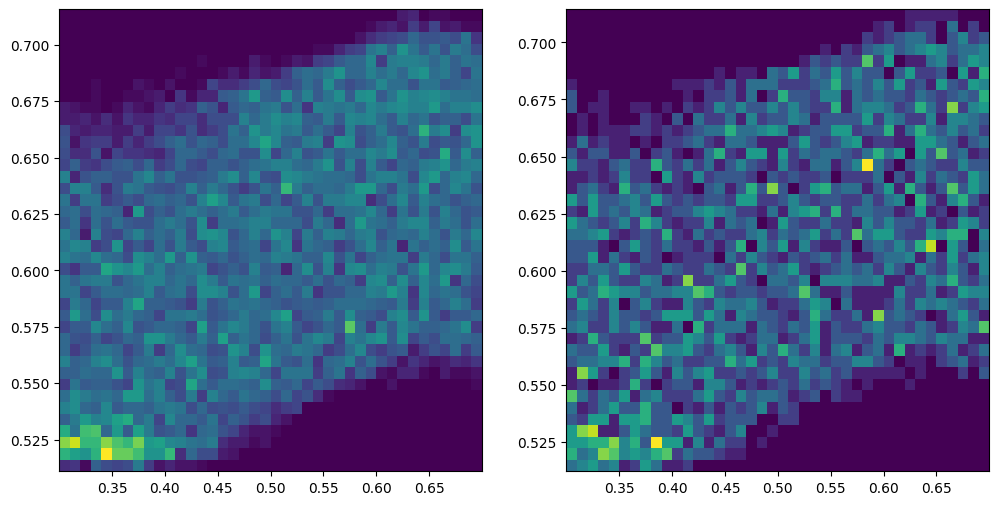

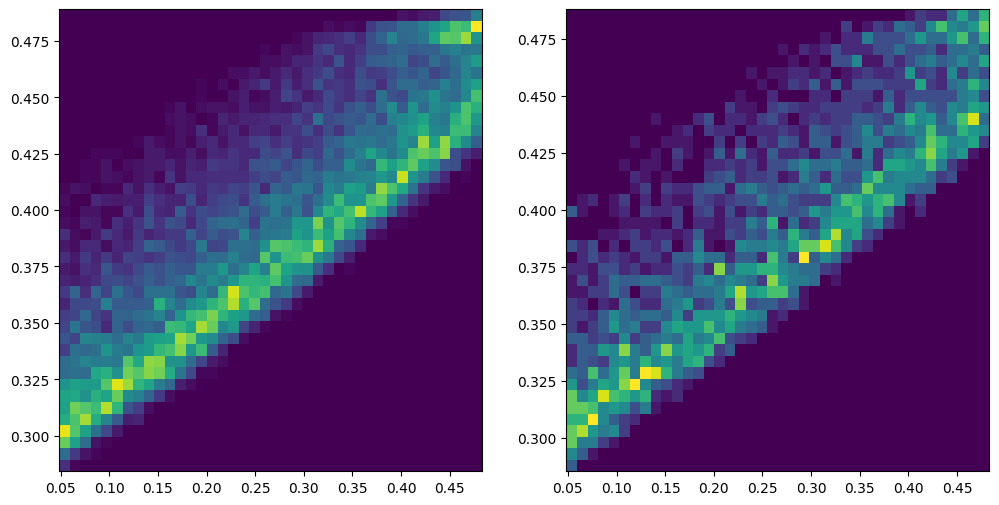

In [12]:
nbins = 40
for i in range(num_truths_to_use):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
    ax1.hist2d(train_truth[:,i].ravel(), train_prediction[:,i].ravel(), bins=nbins)
    ax2.hist2d(test_truth[:,i].ravel(), test_prediction[:,i].ravel(), bins=nbins)
    #ax1.set_xlim(0, 1); ax1.set_ylim(0, 1); ax2.set_xlim(0, 1); ax2.set_ylim(0, 1)
    plt.show()